# Uso de transfer-learning para dataset cat-vs-dogs

---


A estrutura do dataset é a seguinte:
```
cats_and_dogs
|__ train:
    |______ cats: [cat.0.jpg, cat.1.jpg ...]
    |______ dogs: [dog.0.jpg, dog.1.jpg ...]
|__ validation:
    |______ cats: [cat.2000.jpg, cat.2001.jpg ...]
    |______ dogs: [dog.2000.jpg, dog.2001.jpg ...]
|__ test: [1.jpg, 2.jpg ...]
```


In [32]:
import os
import requests

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Baixar zip

In [4]:
url = "https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip"
r = requests.get(url, allow_redirects=True)

try:
    open('cats_vs_dogs.zip', 'wb').write(r.content)
except Exception as e:
    print(f"Error {str(e)}")

In [33]:
PATH = "Dataset"

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

In [35]:
# Variables for pre-processing and training.
batch_size = 128
epochs = 1
IMG_HEIGHT = 160
IMG_WIDTH = 160

In [36]:
train_image_generator = ImageDataGenerator(rescale=1/255)
validation_image_generator = ImageDataGenerator(rescale=1/255)
test_image_generator = ImageDataGenerator(rescale=1/255)

train_data_gen = train_image_generator.flow_from_directory(train_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), class_mode="binary", batch_size=batch_size, color_mode="rgb", seed=42)
val_data_gen = validation_image_generator.flow_from_directory(validation_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), class_mode="binary", batch_size=batch_size, color_mode="rgb", seed=42)
test_data_gen = test_image_generator.flow_from_directory(test_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), shuffle=False, color_mode="rgb", class_mode=None, classes=None)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


## Gerar função para criar visualização dos das imagens

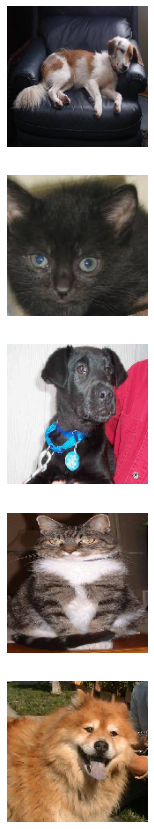

In [37]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
        for img, ax in zip( images_arr, axes):
            ax.imshow(img)
            ax.axis('off')
    else:
        for img, probability, ax in zip( images_arr, probabilities, axes):
            ax.imshow(img)
            ax.axis('off')
            if probability > 0.5:
                ax.set_title("%.2f" % (probability*100) + "% dog")
            else:
                ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

## Definindo funções de augmentation

In [38]:
train_image_generator = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, width_shift_range=0.3, height_shift_range=0.3, rotation_range=90, shear_range=0.1, rescale=1/255)
validation_image_generator = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90, rescale=1/255)

Found 2000 images belonging to 2 classes.


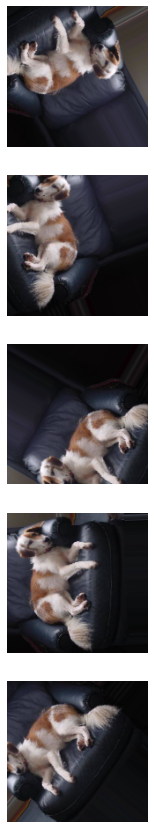

In [39]:
train_data_gen = train_image_generator.flow_from_directory(train_dir, 
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode="binary",
                                                           batch_size=batch_size,
                                                           color_mode="rgb",
                                                           seed=42)

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

## Criando modelo para classificação

In [40]:
class cat_dog_network(tf.keras.Model):
    def __init__(self, backbone, output_units):
        super(cat_dog_network, self).__init__()
        self.backbone = backbone
        self.dense_layer = Dense(output_units, activation="sigmoid")

    def call(self, inputs, training=False):
        x = self.backbone(inputs, training)
        x = tf.keras.layers.Flatten()(x)
        outputs = self.dense_layer(x)
        return outputs

### Baixando modelos do keras

Para mais informações entrar em: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [41]:
conv_layers = tf.keras.applications.MobileNet(include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

conv_layers.trainable=False

conv_layers.summary()

17227776/17225924 [==============================] - 1s 0us/step
Model: "mobilenet_1.00_160"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 161, 161, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 80, 80, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 80, 80, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 80, 80, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 80, 80, 32)        288       
_________________________________________________

In [42]:
new_model = cat_dog_network(conv_layers, output_units=1)

In [43]:
new_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [44]:
history = new_model.fit(train_data_gen, epochs=epochs, validation_data=val_data_gen, validation_steps=total_val/batch_size)

16/16 [==============================] - 16s 1s/step - loss: 0.9701 - accuracy: 0.7110 - val_loss: 0.1896 - val_accuracy: 0.9460


In [45]:
new_model.summary()

Model: "cat_dog_network_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_160 (Function (None, 5, 5, 1024)        3228864   
_________________________________________________________________
dense_4 (Dense)              multiple                  25601     
Total params: 3,254,465
Trainable params: 25,601
Non-trainable params: 3,228,864
_________________________________________________________________


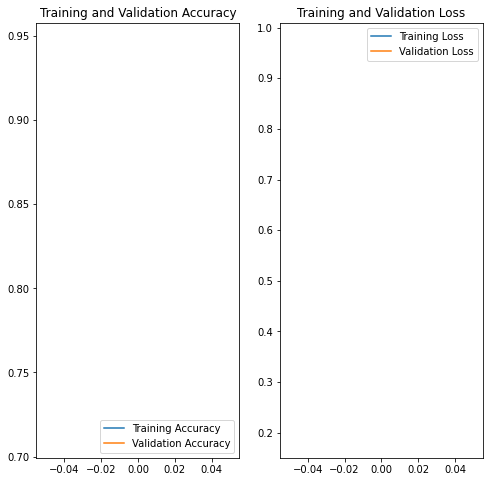

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

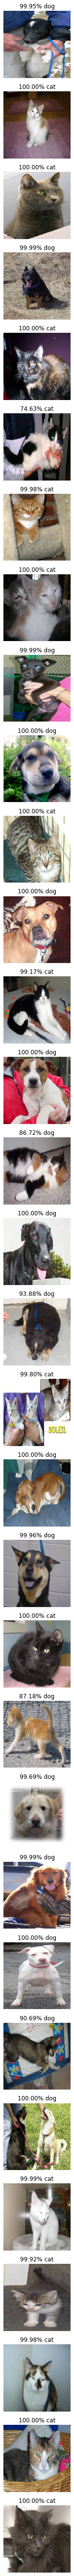

In [47]:
probabilities = new_model.predict(test_data_gen)

sample_test_images = next(test_data_gen)

plotImages(sample_test_images, probabilities=probabilities)

# Exemplo de como salvar e reusar os modelos treinados

In [48]:
new_model.save("pretrained_model")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: pretrained_model/assets


In [49]:
loaded_model = tf.keras.models.load_model("pretrained_model")

In [50]:
loaded_model.summary()

Model: "cat_dog_network_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_160 (Function (None, 5, 5, 1024)        3228864   
_________________________________________________________________
dense_4 (Dense)              multiple                  25601     
Total params: 3,254,465
Trainable params: 25,601
Non-trainable params: 3,228,864
_________________________________________________________________


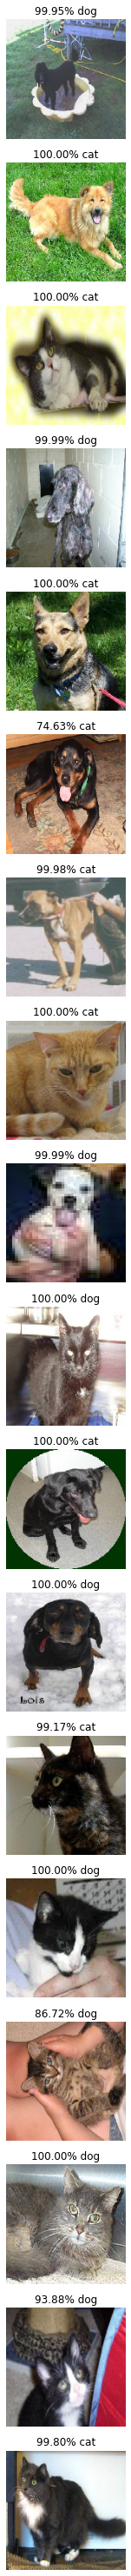

In [51]:
probabilities = loaded_model.predict(test_data_gen)

sample_test_images = next(test_data_gen)

plotImages(sample_test_images, probabilities=probabilities)